In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.utils import resample

# Import NLTK and download required resources
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.stem import LancasterStemmer, WordNetLemmatizer

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# Import other libraries
import re
import string
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import wordcloud
from wordcloud import STOPWORDS, WordCloud
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    precision_recall_fscore_support
)

# Set options for displaying data
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)


import warnings
warnings.filterwarnings(action='ignore')

## data loading

In [2]:
df = pd.read_csv('Tweets.csv') #February of 2015 data
print(df.shape)
df.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## data exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

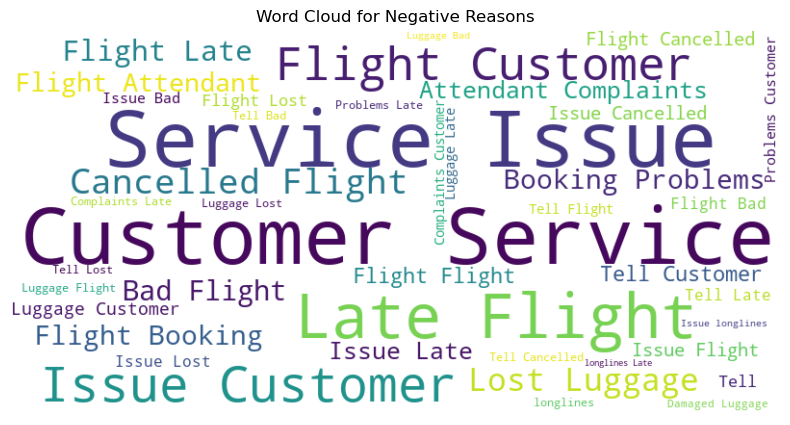

In [5]:
# Filter out rows where 'negativereason' is not null
filtered_df = df[df['negativereason'].notnull()]

# Join the text from all rows into a single string
text = ' '.join(filtered_df['negativereason'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reasons')
plt.show()

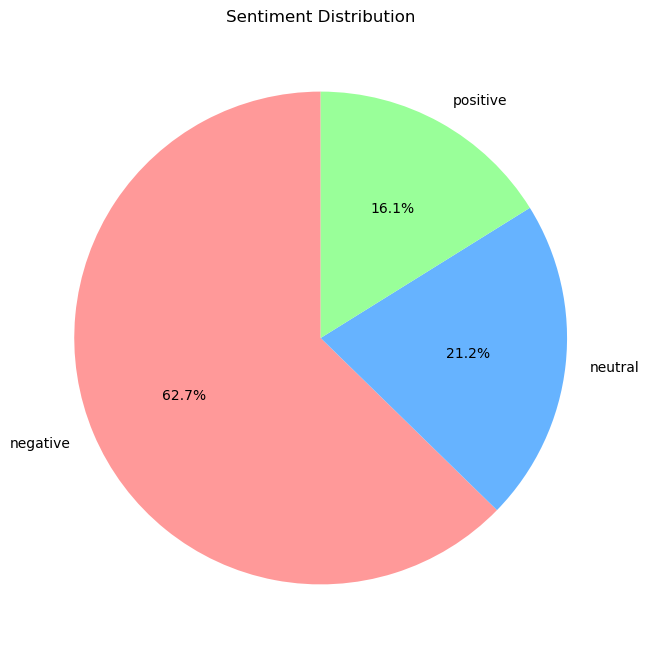

In [89]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'airline_sentiment' is the column containing sentiments
sentiment_distribution = df['airline_sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Sentiment Distribution')
plt.show()


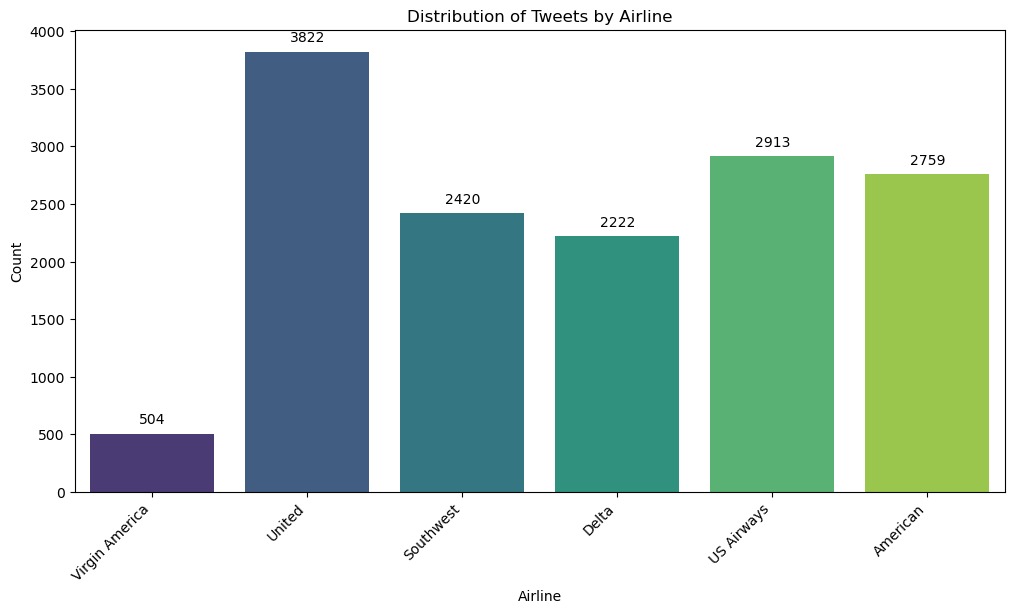

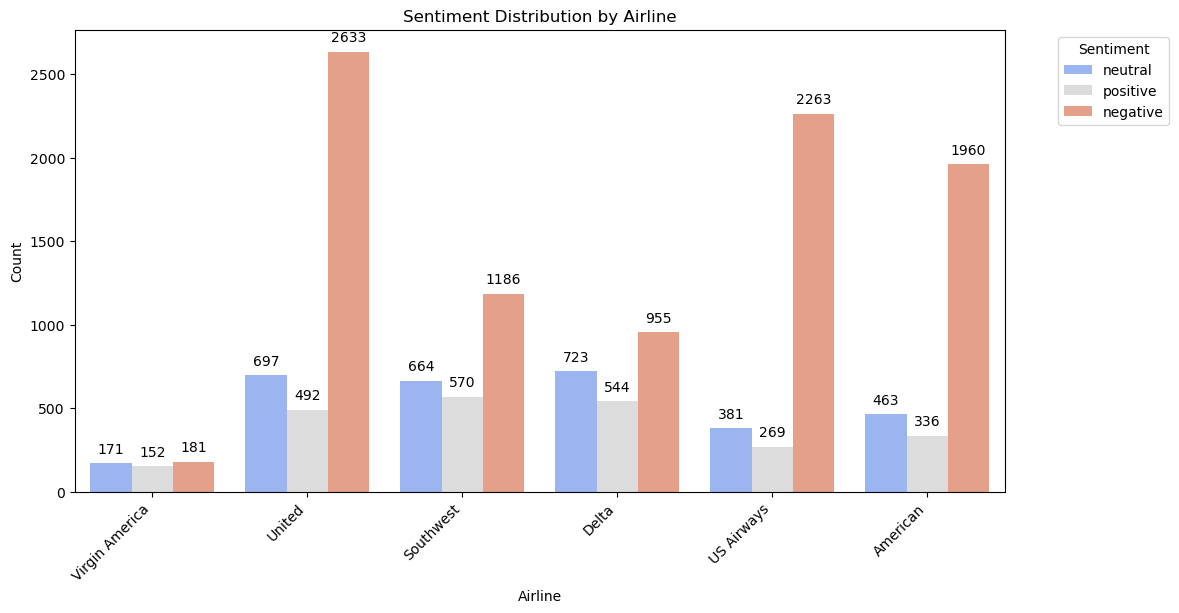

In [6]:
# Create a subset with relevant columns
subset_columns = ['airline', 'airline_sentiment']
subset_df = df[subset_columns]

# Plot histogram for 'airline'
plt.figure(figsize=(12, 6))
ax1 = sns.countplot(data=subset_df, x='airline', palette='viridis')
plt.title('Distribution of Tweets by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add numeric label values
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

# Plot stacked bar chart for 'airline_sentiment' within each airline
plt.figure(figsize=(12, 6))
ax2 = sns.countplot(data=subset_df, x='airline', hue='airline_sentiment', palette='coolwarm')
plt.title('Sentiment Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numeric label values
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [98]:
# Filter only positive and negative sentiments
df_pos_neg = df[df['airline_sentiment'].isin(['positive', 'negative'])]

# Count the number of positive and negative tweets for each airline
sentiment_counts = df_pos_neg.groupby(['airline', 'airline_sentiment']).size().unstack(fill_value=0)

# Calculate the ratio of positive to negative feedback for each airline
sentiment_counts['positive_to_negative_ratio'] = sentiment_counts['positive'] / sentiment_counts['negative']

# Display the resulting DataFrame
print(sentiment_counts)


airline_sentiment  negative  positive  positive_to_negative_ratio
airline                                                          
American               1960       336                    0.171429
Delta                   955       544                    0.569634
Southwest              1186       570                    0.480607
US Airways             2263       269                    0.118869
United                 2633       492                    0.186859
Virgin America          181       152                    0.839779


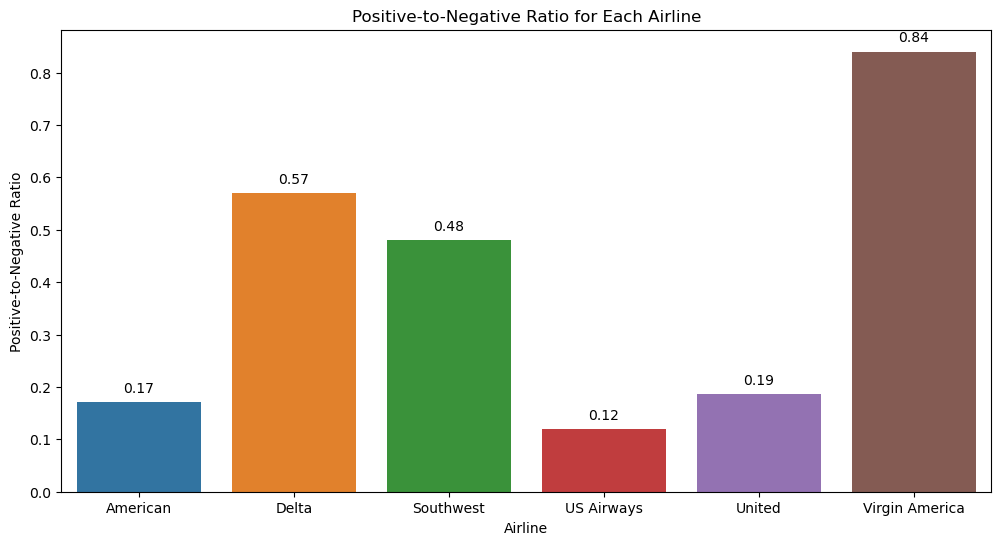

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming sentiment_counts DataFrame from the previous code
# Replace 'sentiment_counts' with your actual DataFrame name

# Set up the plot
plt.figure(figsize=(12, 6))

# Create a bar chart for positive-to-negative ratios
bar_chart = sns.barplot(x=sentiment_counts.index, y='positive_to_negative_ratio', data=sentiment_counts)

# Add text annotations for values on top of the bars
for p in bar_chart.patches:
    bar_chart.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, 10), 
                       textcoords='offset points')

# Add labels and title
plt.xlabel('Airline')
plt.ylabel('Positive-to-Negative Ratio')
plt.title('Positive-to-Negative Ratio for Each Airline')

# Display the plot
plt.show()


In [103]:
# Assuming you have sentiment_counts DataFrame from the previous code
# Replace 'sentiment_counts' with your actual DataFrame name

# Calculate positive-to-negative ratio
sentiment_counts['positive_to_negative_ratio'] = sentiment_counts['positive_count'] / sentiment_counts['negative_count']

# Display the DataFrame to check the calculated ratios
print(sentiment_counts[['positive_count', 'negative_count', 'positive_to_negative_ratio']])


KeyError: 'positive_count'

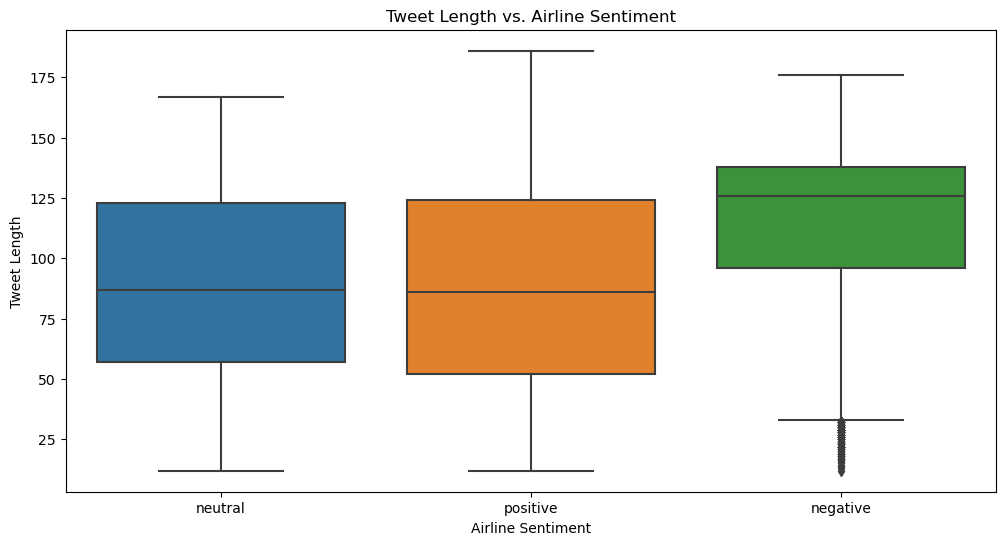

In [7]:
# Create a new column 'tweet_length' representing the length of each tweet
df['tweet_length'] = df['text'].apply(len)

# Plot a boxplot to show the relationship between tweet length and airline sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='airline_sentiment', y='tweet_length', data=df)
plt.title('Tweet Length vs. Airline Sentiment')
plt.xlabel('Airline Sentiment')
plt.ylabel('Tweet Length')
plt.show()

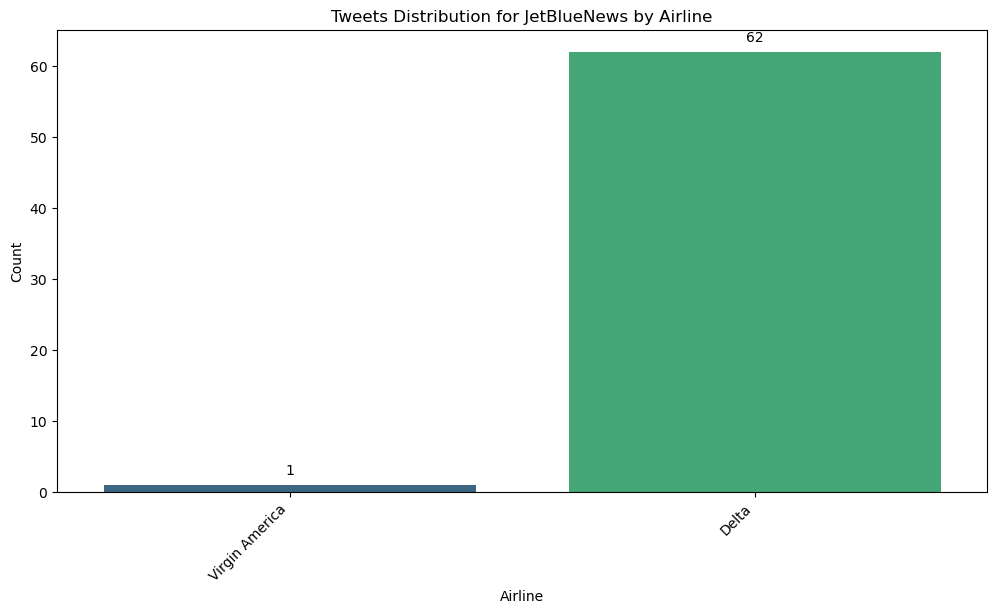

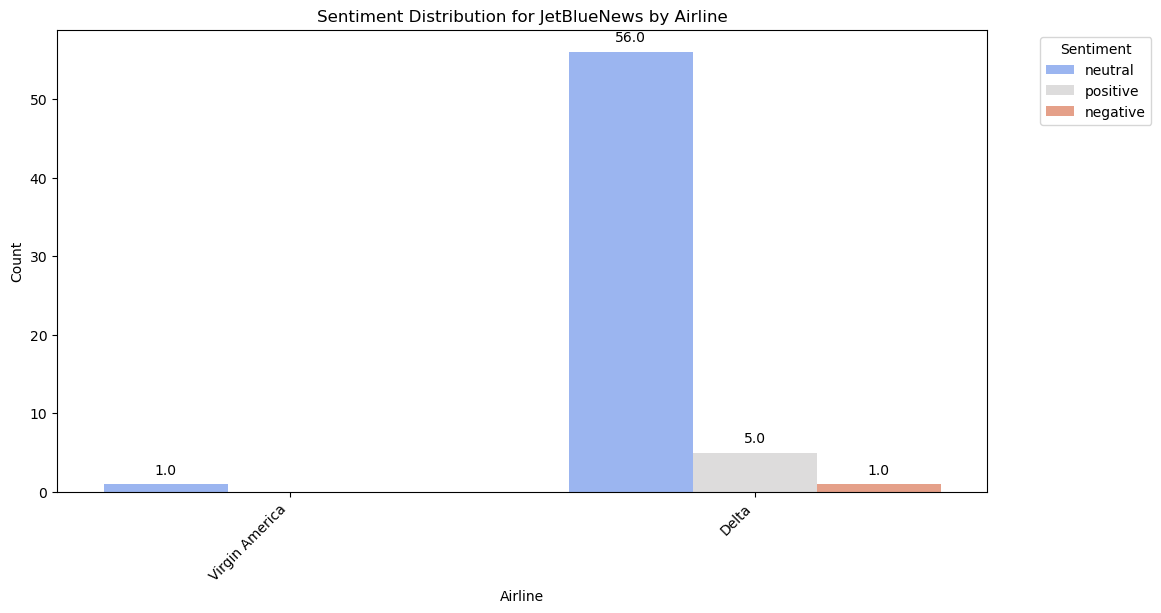

In [8]:
# Create a subset with relevant columns
subset_columns = ['name', 'airline', 'airline_sentiment']
subset_df = df[subset_columns]

# Find the person with the highest number of tweets
top_person = subset_df['name'].value_counts().idxmax()

# Filter the data for the top person
top_person_df = subset_df[subset_df['name'] == top_person]

# Plot histogram for 'airline'
plt.figure(figsize=(12, 6))
ax1 = sns.countplot(data=top_person_df, x='airline', palette='viridis')
plt.title(f'Tweets Distribution for {top_person} by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add numeric label values
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

# Plot stacked bar chart for 'airline_sentiment' within each airline for the top person
plt.figure(figsize=(12, 6))
ax2 = sns.countplot(data=top_person_df, x='airline', hue='airline_sentiment', palette='coolwarm')
plt.title(f'Sentiment Distribution for {top_person} by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numeric label values
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [9]:
df.retweet_count.value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
28        1
9         1
18        1
11        1
31        1
15        1
44        1
Name: retweet_count, dtype: int64

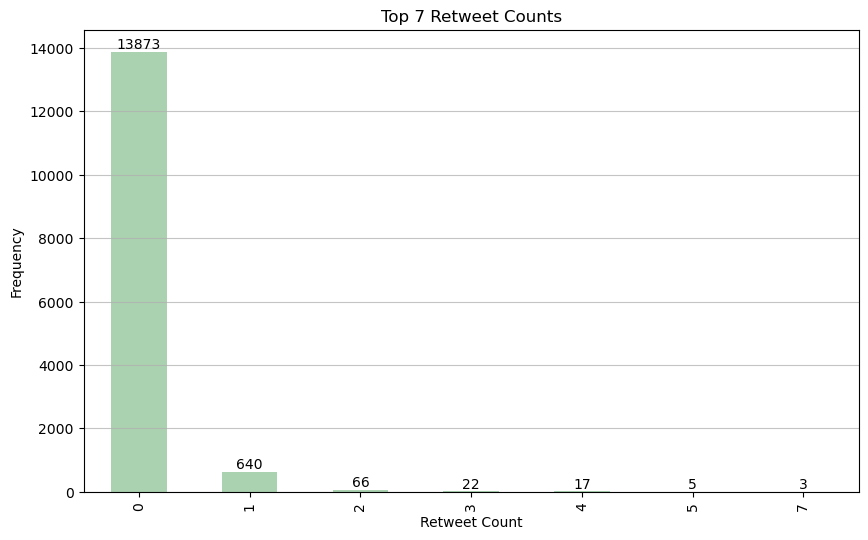

In [97]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'retweet_count' is the column containing retweet counts
top_retweet_counts = df['retweet_count'].value_counts().head(7)

# Create a bar plot for the top ten retweet counts
plt.figure(figsize=(10, 6))
top_retweet_counts.plot(kind='bar', color='#86bf91', alpha=0.7)
plt.title('Top 7 Retweet Counts')
plt.xlabel('Retweet Count')
plt.ylabel('Frequency')
for i, count in enumerate(top_retweet_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.grid(axis='y', alpha=0.75)
plt.show()

## data preprocessing

In [10]:
# dropping negativereason negativereason_confidence airline_sentiment_gold negativereason_gold tweet_coord
columns_to_drop = ['negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'negativereason_gold',
                   'tweet_coord']
df = df.drop(columns=columns_to_drop, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   airline                       14640 non-null  object 
 4   name                          14640 non-null  object 
 5   retweet_count                 14640 non-null  int64  
 6   text                          14640 non-null  object 
 7   tweet_created                 14640 non-null  object 
 8   tweet_location                9907 non-null   object 
 9   user_timezone                 9820 non-null   object 
 10  tweet_length                  14640 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 1.2+ MB


In [11]:
df.tweet_location.value_counts()

Boston, MA              157
New York, NY            156
Washington, DC          150
New York                127
USA                     126
                       ... 
Seattle (duh!)            1
South ~O-H-I-O~ Side      1
Pocono Raceway            1
denver, co                1
Nigeria,lagos             1
Name: tweet_location, Length: 3081, dtype: int64

In [12]:
# Clean the 'tweet_location' column by removing special characters
df['tweet_location'] = df['tweet_location'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)

# Remove the last three characters after the last space in 'clean_location'
df['tweet_location'] = df['tweet_location'].str.replace(r'\s\S\S$', '', regex=True)
df.tweet_location.value_counts()

Washington                    292
New York                      286
Boston                        225
Chicago                       191
San Francisco                 186
                             ... 
Seattle duh                     1
South OHIO Side                 1
Pocono Raceway                  1
 Maryland  North Carolina       1
Nigerialagos                    1
Name: tweet_location, Length: 2788, dtype: int64

In [13]:
# Impute 'tweet_location' with a unique identifier (e.g., 'Unknown')
df['tweet_location'].fillna('Unknown', inplace=True)

# Impute 'user_timezone' with a unique identifier (e.g., 'Unknown')
df['user_timezone'].fillna('Unknown', inplace=True)

In [14]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

# Extract date and time into separate columns
df['tweet_date'] = df['tweet_created'].dt.date
df['tweet_time'] = df['tweet_created'].dt.time

# Convert time to the hour of the day
df['tweet_hour'] = df['tweet_created'].dt.hour

In [15]:
df.isnull().sum()

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
airline                         0
name                            0
retweet_count                   0
text                            0
tweet_created                   0
tweet_location                  0
user_timezone                   0
tweet_length                    0
tweet_date                      0
tweet_time                      0
tweet_hour                      0
dtype: int64

## temporal trends

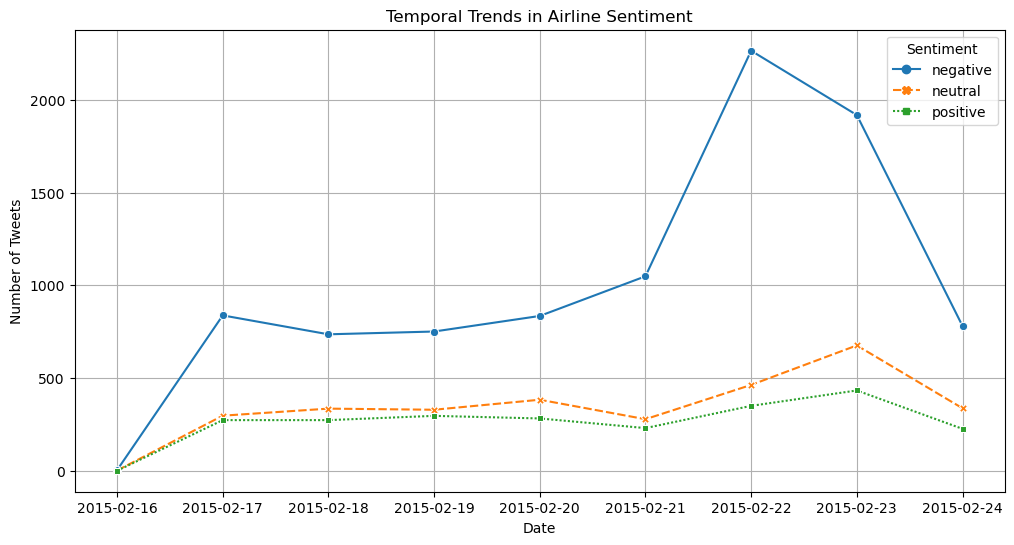

In [16]:
# Set 'tweet_created' as the index for time series analysis
df1 = df.copy()

df1['tweet_created'] = pd.to_datetime(df1['tweet_created'])

df1.set_index('tweet_created', inplace=True)

# Resample the data to a specific time frequency (e.g., daily)
resampled_data = df1.resample('D')['airline_sentiment'].value_counts().unstack().fillna(0)

# Plot temporal trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=resampled_data, markers=True)
plt.title('Temporal Trends in Airline Sentiment')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment', loc='upper right')
plt.grid(True)
plt.show()

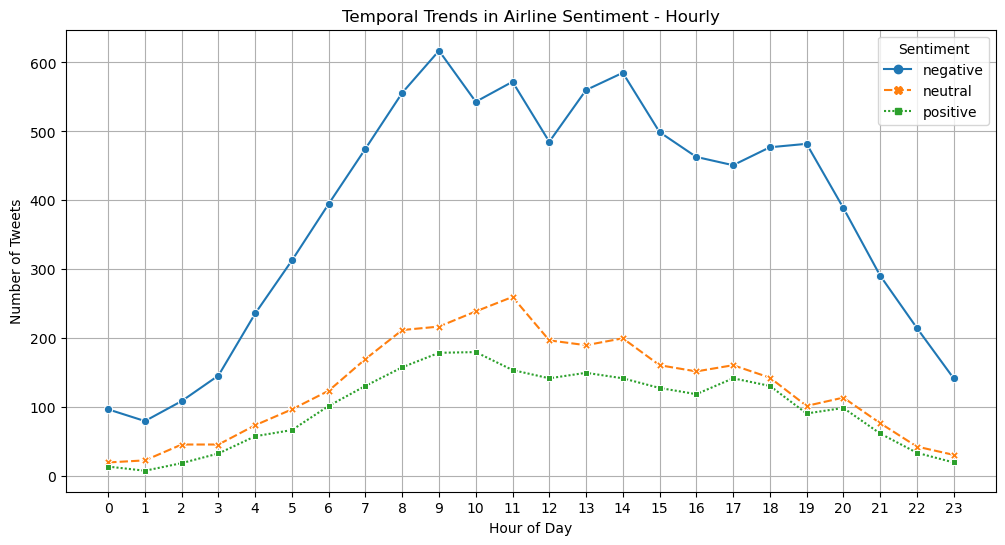

In [17]:
df1 = df.copy()

# Convert 'tweet_created' to datetime format
df1['tweet_created'] = pd.to_datetime(df1['tweet_created'])

# Set 'tweet_created' as the index for time series analysis
df1.set_index('tweet_created', inplace=True)

# Group by hour and sentiment, then count the occurrences
hourly_counts = df1.groupby([df1.index.hour, 'airline_sentiment']).size().unstack().fillna(0)

# Plot temporal trends by the hour of the day
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_counts, markers=True)
plt.title('Temporal Trends in Airline Sentiment - Hourly')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment', loc='upper right')

# Set x-axis ticks to show every hour
plt.xticks(range(24))

plt.grid(True)
plt.show()

## Geographic Variation

<Figure size 2000x800 with 0 Axes>

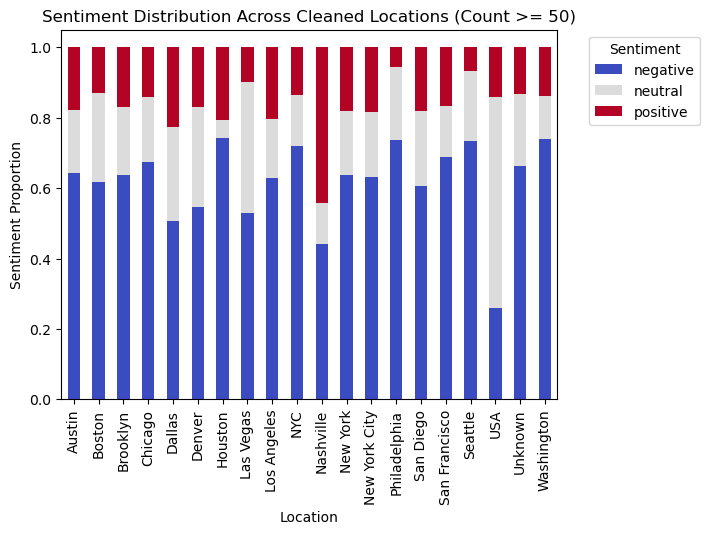

In [18]:
# Create a subset with relevant columns
subset_columns = ['airline_sentiment', 'tweet_location']
subset_df = df[subset_columns]

# Clean the 'tweet_location' column by removing special characters
subset_df['clean_location'] = subset_df['tweet_location'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)

# Filter out locations with value counts less than 5
location_counts = subset_df['clean_location'].value_counts()
valid_locations = location_counts[location_counts >= 50].index
subset_df_filtered = subset_df[subset_df['clean_location'].isin(valid_locations) | subset_df['clean_location'].isna()]

# Group by cleaned location and calculate the average sentiment for each location
location_sentiment = subset_df_filtered.groupby('clean_location')['airline_sentiment'].value_counts(normalize=True).unstack()

# Plot a bar chart to visualize sentiment distribution across cleaned locations
plt.figure(figsize=(20, 8))
location_sentiment.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Sentiment Distribution Across Cleaned Locations (Count >= 50)')
plt.xlabel('Location')
plt.ylabel('Sentiment Proportion')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 5 categories

In [19]:
# Define conditions
conditions = [
    (df['airline_sentiment'] == 'negative') & (df['airline_sentiment_confidence'] >= 0.8),
    (df['airline_sentiment'] == 'negative') & (df['airline_sentiment_confidence'] < 0.8),
    (df['airline_sentiment'] == 'neutral'),
    (df['airline_sentiment'] == 'positive') & (df['airline_sentiment_confidence'] < 0.8),
    (df['airline_sentiment'] == 'positive') & (df['airline_sentiment_confidence'] >= 0.8)
]

# Define values for each condition
values = [1, 2, 3, 4, 5]

# Create 'positivity' column based on conditions
df['positivity'] = np.select(conditions, values, default=np.nan)
df['positivity'].value_counts()

1.0    7392
3.0    3099
2.0    1786
5.0    1517
4.0     846
Name: positivity, dtype: int64

In [20]:
#### balancing the dataset
# Separate the DataFrame into different positivity categories
df_1 = df[df['positivity'] == 1.0]
df_2 = df[df['positivity'] == 2.0]
df_3 = df[df['positivity'] == 3.0]
df_4 = df[df['positivity'] == 4.0]
df_5 = df[df['positivity'] == 5.0]

# Determine the target number of samples based on the category with the minimum count
target_samples = min(len(df_1), len(df_2), len(df_3), len(df_4), len(df_5))

# Resample each category to have the target number of samples
df_1_resampled = resample(df_1, replace=True, n_samples=target_samples, random_state=42)
df_2_resampled = resample(df_2, replace=True, n_samples=target_samples, random_state=42)
df_3_resampled = resample(df_3, replace=True, n_samples=target_samples, random_state=42)
df_4_resampled = resample(df_4, replace=True, n_samples=target_samples, random_state=42)
df_5_resampled = resample(df_5, replace=True, n_samples=target_samples, random_state=42)

# Concatenate the resampled DataFrames to create a balanced dataset
df_balanced = pd.concat([df_1_resampled, df_2_resampled, df_3_resampled, df_4_resampled, df_5_resampled])

# Shuffle the rows in the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced['positivity'].value_counts()

3.0    846
4.0    846
5.0    846
1.0    846
2.0    846
Name: positivity, dtype: int64

In [21]:
df_balanced.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'airline', 'name', 'retweet_count', 'text', 'tweet_created',
       'tweet_location', 'user_timezone', 'tweet_length', 'tweet_date',
       'tweet_time', 'tweet_hour', 'positivity'],
      dtype='object')

## Sentiment Impact

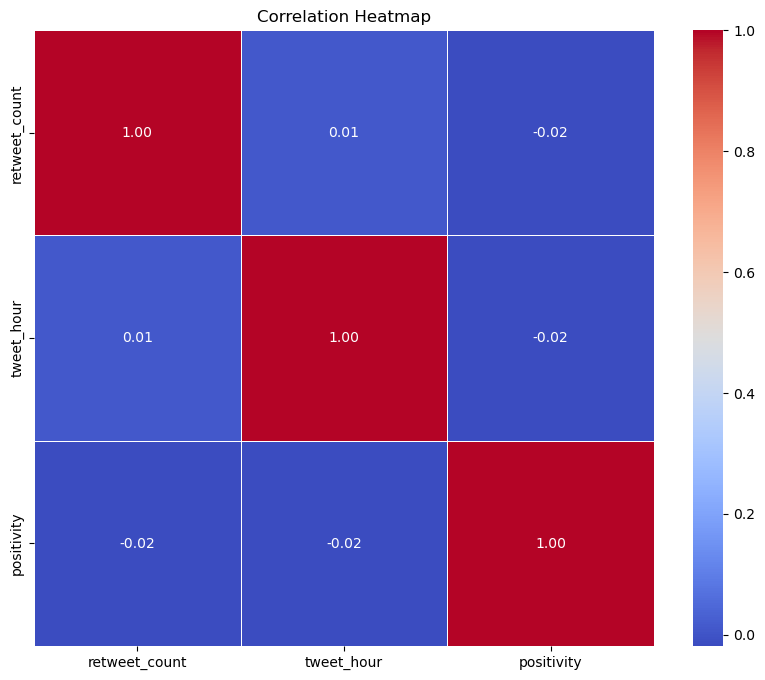

In [22]:
# Select relevant columns
selected_columns = ['retweet_count', 'tweet_hour', 'positivity']

# Create a subset of the DataFrame with selected columns
subset_df = df_balanced[selected_columns]

# Calculate correlation matrix
correlation_matrix = subset_df.corr()

# Create a heatmap with values
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## model

In [60]:
df_model = df_balanced[['text','positivity']]
df_model.head()

,text,positivity
0,@JetBlue marks 15th birthday with @Airbus #A32...,3.0
1,"alright @JetBlue.... done! alternatively, if y...",4.0
2,@united appreciate the sentiment and you were ...,4.0
3,@united Confirmation number: NJV4BP - All I ne...,3.0
4,"@JetBlue Utah, I think. And thanks!",5.0


In [61]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return(" ".join( meaningful_words ))

In [62]:
df_model["clean_tweet"] = df_model["text"].apply(lambda x: tweet_to_words(x))
df_model.head()

,text,positivity,clean_tweet
0,@JetBlue marks 15th birthday with @Airbus #A32...,3.0,jetblue marks th birthday airbus painted bluma...
1,"alright @JetBlue.... done! alternatively, if y...",4.0,alright jetblue done alternatively like charte...
2,@united appreciate the sentiment and you were ...,4.0,united appreciate sentiment able get ground st...
3,@united Confirmation number: NJV4BP - All I ne...,3.0,united confirmation number njv bp need email c...
4,"@JetBlue Utah, I think. And thanks!",5.0,jetblue utah think thanks


In [63]:
X = df_model["clean_tweet"]
y = df_model["positivity"]

In [64]:
print(X.shape, y.shape)

(4230,) (4230,)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 42)

In [66]:
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [67]:
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [68]:
vect_tunned = CountVectorizer(stop_words = "english", ngram_range = (1, 2), min_df = 0.1, max_df = 0.7, max_features = 100)
vect_tunned

CountVectorizer(max_df=0.7, max_features=100, min_df=0.1, ngram_range=(1, 2),
                stop_words='english')

In [32]:
from sklearn.svm import SVC
model = SVC(kernel = "linear", random_state = 10)
model.fit(X_train_dtm, y_train)
pred = model.predict(X_test_dtm)

In [33]:
print("Accuracy Score: ", accuracy_score(y_test, pred) * 100)

Accuracy Score:  63.593380614657214


In [34]:
print("Confusion Matrix\n\n", confusion_matrix(y_test, pred))

Confusion Matrix

 [[104  28  19   6   5]
 [ 33  84  29   8   3]
 [  8  31 112   9   7]
 [ 10  16  16 121  22]
 [  8   5  11  34 117]]


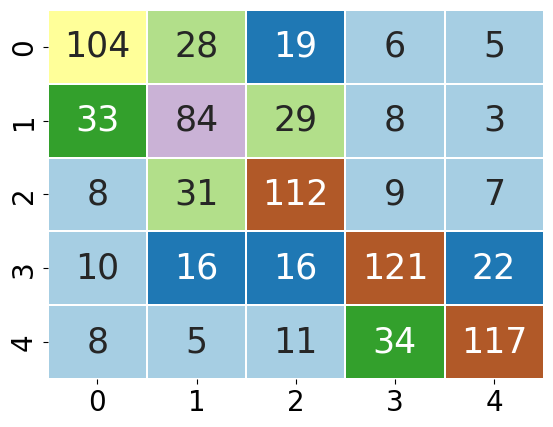

In [35]:
# Assuming that 'y_test' and 'pred' contain labels for a multi-class problem with three classes
conf_matrix = pd.DataFrame(data=confusion_matrix(y_test, pred))

# Plot the 3x3 confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Paired', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [36]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.64      0.64      0.64       162
         2.0       0.51      0.54      0.52       157
         3.0       0.60      0.67      0.63       167
         4.0       0.68      0.65      0.67       185
         5.0       0.76      0.67      0.71       175

    accuracy                           0.64       846
   macro avg       0.64      0.63      0.63       846
weighted avg       0.64      0.64      0.64       846



## TFIDF

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create and fit TF-IDF vectorizer on training data
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [38]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVM
param_grid = {'C': [1], 'kernel': ['linear', 'rbf']}

# Perform grid search
grid_search = GridSearchCV(SVC(random_state=10), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train SVM with the best parameters
best_model = SVC(**best_params, random_state=10)
best_model.fit(X_train_tfidf, y_train)

# Predictions
pred_tfidf = best_model.predict(X_test_tfidf)

Best Parameters: {'C': 1, 'kernel': 'rbf'}


In [39]:
best_model

SVC(C=1, random_state=10)

In [40]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.59231905 0.59231905 0.58493353 0.61152142 0.6183432 ]


In [41]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:\n", classification_report(y_test, pred_tfidf))

Classification Report:
               precision    recall  f1-score   support

         1.0       0.59      0.74      0.66       162
         2.0       0.48      0.46      0.47       157
         3.0       0.56      0.66      0.60       167
         4.0       0.74      0.60      0.66       185
         5.0       0.76      0.64      0.70       175

    accuracy                           0.62       846
   macro avg       0.63      0.62      0.62       846
weighted avg       0.63      0.62      0.62       846



## Glove

In [58]:
# Word Embeddings (using pre-trained GloVe embeddings)
from sklearn.feature_extraction.text import TfidfVectorizer

# Load pre-trained GloVe embeddings
glove_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=10000)
X_train_glove = glove_vectorizer.fit_transform(X_train)
X_test_glove = glove_vectorizer.transform(X_test)

# SVM with RBF kernel and tuned parameters
svm_glove = SVC(C=1, kernel='rbf', random_state=10)
svm_glove.fit(X_train_glove, y_train)

# Predictions
pred_glove = svm_glove.predict(X_test_glove)


In [59]:
print("Accuracy Score: ", accuracy_score(y_test,pred_glove) * 100)

Accuracy Score:  62.4113475177305


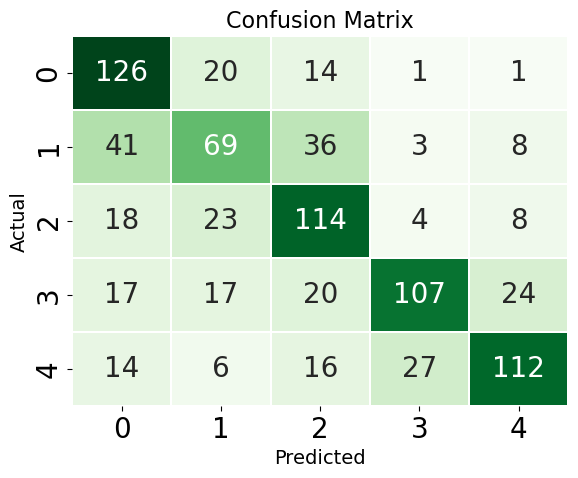

In [88]:
# Assuming that 'y_test' and 'pred' contain labels for a multi-class problem with 5 classes
conf_matrix = pd.DataFrame(data=confusion_matrix(y_test, pred_glove))

# Plot the 3x3 confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, linewidths=0.1, annot_kws={'size': 20})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [75]:
# Sample text for prediction
sample_text = ["I really enjoyed the flight, great experience!"]

# Transform the sample text using the same vectorizer
sample_text_glove = glove_vectorizer.transform(sample_text)

# Predict positivity for the sample text
predicted_positivity = svm_glove.predict(sample_text_glove)

# Print the predicted positivity value
print("Predicted Positivity:", predicted_positivity)

Predicted Positivity: [5.]


In [76]:
# Sample text for prediction
sample_text = ["the flight was okay"]

# Transform the sample text using the same vectorizer
sample_text_glove = glove_vectorizer.transform(sample_text)

# Predict positivity for the sample text
predicted_positivity = svm_glove.predict(sample_text_glove)

# Print the predicted positivity value
print("Predicted Positivity:", predicted_positivity)

Predicted Positivity: [2.]


In [77]:
# Sample text for prediction
sample_text = ["poor service and luggage handling"]

# Transform the sample text using the same vectorizer
sample_text_glove = glove_vectorizer.transform(sample_text)

# Predict positivity for the sample text
predicted_positivity = svm_glove.predict(sample_text_glove)

# Print the predicted positivity value
print("Predicted Positivity:", predicted_positivity)

Predicted Positivity: [1.]
